In [ ]:
import zipfile

# Path to the uploaded zip file
zip_path = '/content/Teeth DataSet.zip'  # Replace with the name of your uploaded file

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped_folder')  # Extract to a folder named 'unzipped_folder'

In [ ]:
import os

# List files in the unzipped folder
unzipped_folder = '/content/unzipped_folder'
print(os.listdir(unzipped_folder))

['Teeth_Dataset']


In [ ]:
dataset_path = '/content/unzipped_folder/Teeth_Dataset'

In [ ]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'Training'),  # Pass the directory path directly
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=10
)

Found 3087 files belonging to 7 classes.
Using 2470 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_path, 'Validation'),
  validation_split=0.2,
  subset="validation",  # Incorrect value
  seed=123,
  image_size=(180, 180),
  batch_size=10)

Found 1028 files belonging to 7 classes.
Using 205 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


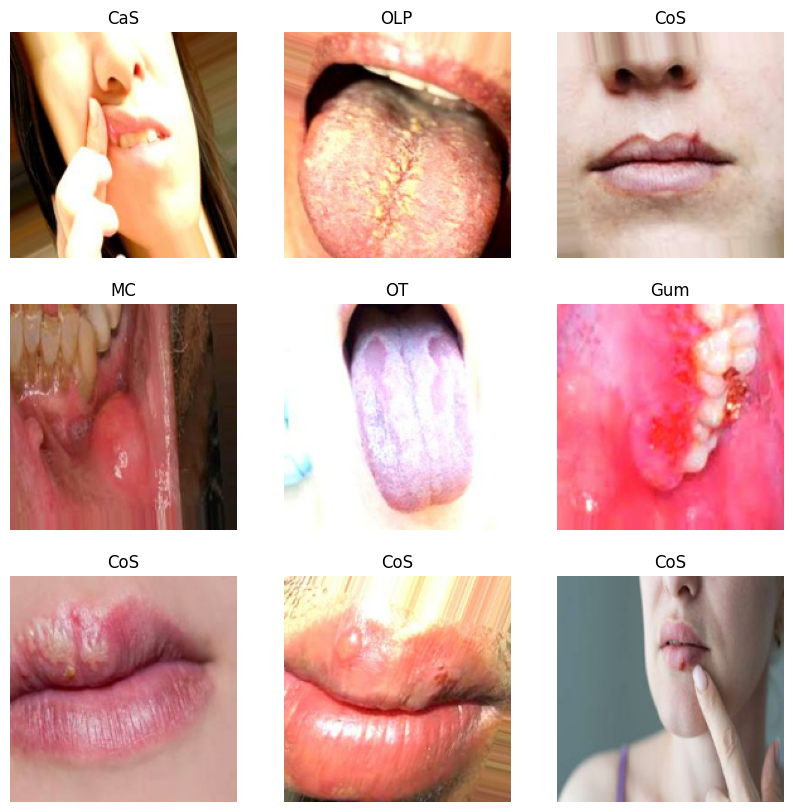

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 180, 180, 3)
(10,)


In [ ]:
from tensorflow.keras import layers, models
import numpy as np

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                 input_shape=(180,180,3)),
                 layers.RandomRotation(0.1),
                 layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


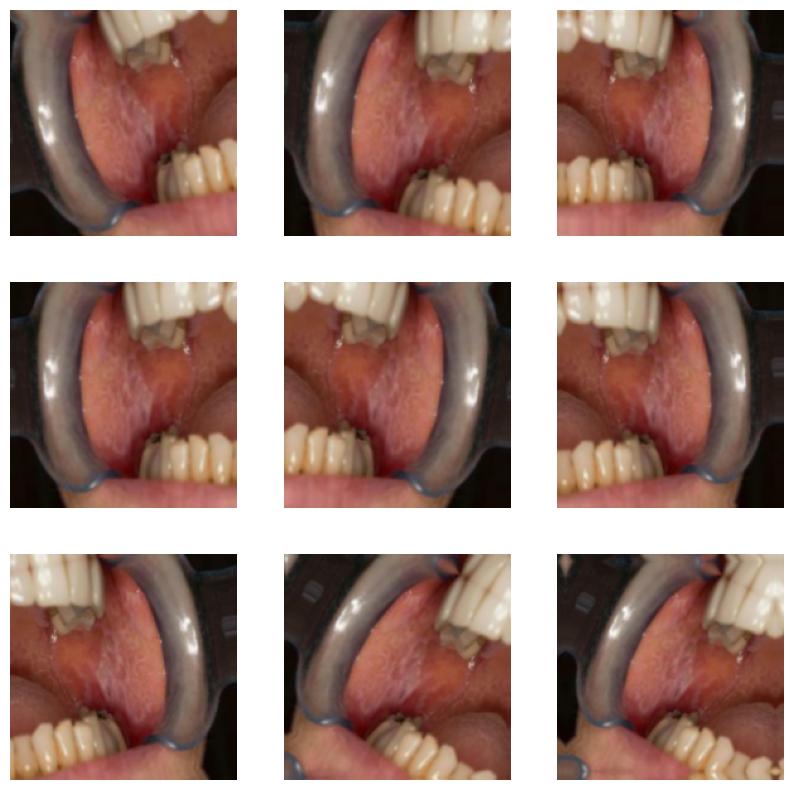

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model =models.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,543 (15.22 MB)

 Trainable params: 3,989,543 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


247/247 ━━━━━━━━━━━━━━━━━━━━ 109s 426ms/step - accuracy: 0.2046 - loss: 1.9207 - val_accuracy: 0.3659 - val_loss: 1.6456
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 101s 408ms/step - accuracy: 0.3532 - loss: 1.6810 - val_accuracy: 0.4732 - val_loss: 1.4788
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 101s 408ms/step - accuracy: 0.4362 - loss: 1.4946 - val_accuracy: 0.4293 - val_loss: 1.3644
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 101s 409ms/step - accuracy: 0.5008 - loss: 1.3138 - val_accuracy: 0.4829 - val_loss: 1.4689
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 102s 412ms/step - accuracy: 0.5855 - loss: 1.1724 - val_accuracy: 0.5805 - val_loss: 1.0791
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 100s 403ms/step - accuracy: 0.6112 - loss: 1.0632 - val_accuracy: 0.6439 - val_loss: 0.9605
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 102s 412ms/step - accuracy: 0.6703 - loss: 0.9252 - val_accuracy: 0.6732 - val_loss: 0.8704
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 142s 411ms/step - accuracy: 0.6719 - loss: 0.90

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_path, 'Testing'),
  seed=123,
  image_size=(180, 180),
  batch_size=20)

Found 1508 files belonging to 10 classes.


76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step
Sample 1:
  Predicted class: CaS
  Confidence score: 69.91%


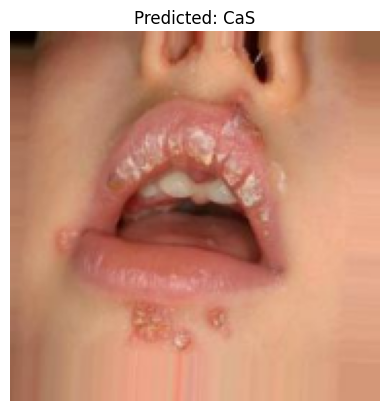

Sample 2:
  Predicted class: OT
  Confidence score: 51.05%


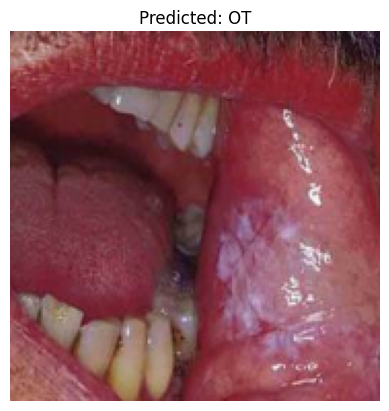

Sample 3:
  Predicted class: OLP
  Confidence score: 62.49%


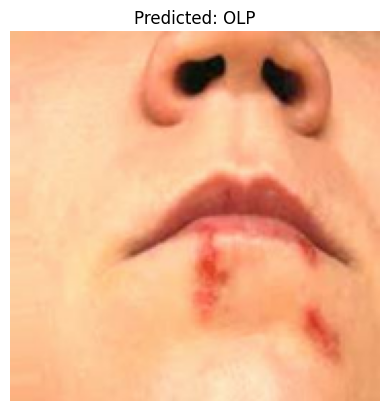

Sample 4:
  Predicted class: OT
  Confidence score: 85.14%


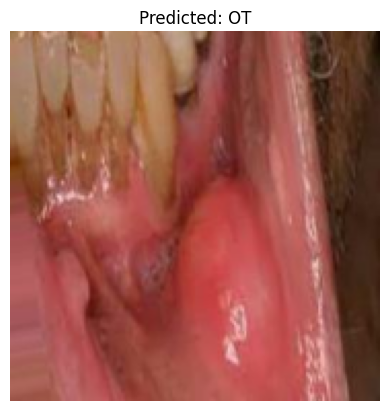

Sample 5:
  Predicted class: MC
  Confidence score: 60.54%


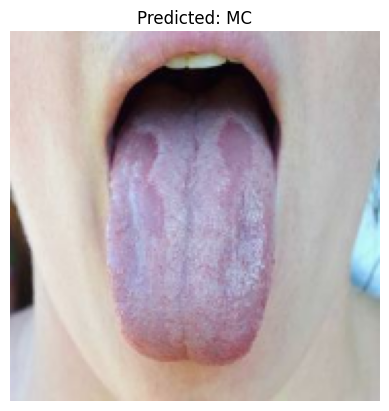

In [ ]:
predictions = model.predict(test_ds)

image_batch, labels_batch = next(iter(test_ds))

num_samples = 5

for i in range(num_samples):
    prediction = predictions[i]

    predicted_class_index = np.argmax(prediction)

    predicted_class_name = class_names[predicted_class_index]

    confidence_score = 100 * np.max(prediction)

    print("Sample {}:".format(i + 1))
    print("  Predicted class: {}".format(predicted_class_name))
    print("  Confidence score: {:.2f}%".format(confidence_score))

    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title("Predicted: {}".format(predicted_class_name))
    plt.axis("off")
    plt.show()